# Day 6: Factor Portfolio Construction

---

### 🎯 Learning Objectives
- Build long-short factor portfolios
- Implement factor neutralization
- Optimize factor-based portfolios
- Backtest factor strategies


---| **Factor timing** | Increase exposure when factor cheap |

| **Multi-factor** | Combine several factor portfolios |

### 📈 Why Factor Portfolios Matter| **Factor tilt** | Overweight high-score stocks |

| **Pure factor bet** | Long-short factor portfolio |

**Factor portfolios are the building blocks of systematic investing.**|----------|---------------|

| Strategy | Implementation |

### Key Concept

A factor portfolio is a **dollar-neutral, long-short portfolio** that isolates exposure to a specific factor.### Trading Applications



### Factor Portfolio Structure| **Factor exposure** | Pure factor bet, minimal other exposures |

| **Dollar neutral** | Long $ = Short $ |

| Component | Description || **Short leg** | Stocks with low factor score |

|-----------|-------------|| **Long leg** | Stocks with high factor score |

In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Constants
TRADING_DAYS = 252  # Trading days per year
RISK_FREE_RATE = 0.05  # Risk-free rate (5%)

# Download market data from Yahoo Finance
# Use a larger universe for meaningful factor portfolios
tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'TSLA',  # Tech
    'JPM', 'GS', 'BAC', 'WFC', 'C',  # Financials
    'JNJ', 'PFE', 'UNH', 'MRK',  # Healthcare
    'XOM', 'CVX', 'COP',  # Energy
    'KO', 'PEP', 'WMT', 'PG', 'HD', 'MCD'  # Consumer
]

end_date = datetime.now()
start_date = end_date - timedelta(days=3*365)  # 3 years of data

print("📥 Downloading data from Yahoo Finance...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna(axis=1)  # Remove any tickers with missing data
returns = prices.pct_change().dropna()
log_returns = np.log(prices / prices.shift(1)).dropna()

# Market proxy (SPY)
market_data = yf.download('SPY', start=start_date, end=end_date, progress=False, auto_adjust=True)
market_returns = market_data['Close'].pct_change().dropna()

print(f"✅ Data loaded: {prices.shape[0]} days, {prices.shape[1]} stocks")
print(f"   Stocks: {list(prices.columns)}")

📥 Downloading data from Yahoo Finance...
✅ Data loaded: 752 days, 25 stocks
   Stocks: ['AAPL', 'AMZN', 'BAC', 'C', 'COP', 'CVX', 'GOOGL', 'GS', 'HD', 'JNJ', 'JPM', 'KO', 'MCD', 'META', 'MRK', 'MSFT', 'NVDA', 'PEP', 'PFE', 'PG', 'TSLA', 'UNH', 'WFC', 'WMT', 'XOM']


## 1. Define Factor Scores

| **Low Vol** | Historical vol | Low vol | High vol |

### 🎯 How to Score Stocks| **Quality** | ROE, margins | High quality | Low quality |

| **Size** | Market cap | Small | Large |

| Factor | Score Definition | Long | Short || **Value** | B/M ratio | High B/M | Low B/M |

|--------|-----------------|------|-------|| **Momentum** | 12-1 month return | High return | Low return |


FACTOR SCORES SUMMARY
       momentum  low_vol    value  quality  reversal
count   25.0000  25.0000  25.0000  25.0000   25.0000
mean     0.1409  -0.0157  -0.0169   0.0492   -0.0015
std      0.2123   0.0045   0.0658   0.0378    0.0304
min     -0.3711  -0.0274  -0.1424  -0.0255   -0.0611
25%      0.0225  -0.0177  -0.0586   0.0225   -0.0203
50%      0.1377  -0.0145  -0.0330   0.0486   -0.0026
75%      0.2342  -0.0121   0.0381   0.0759    0.0165
max      0.5708  -0.0091   0.0846   0.1122    0.0584


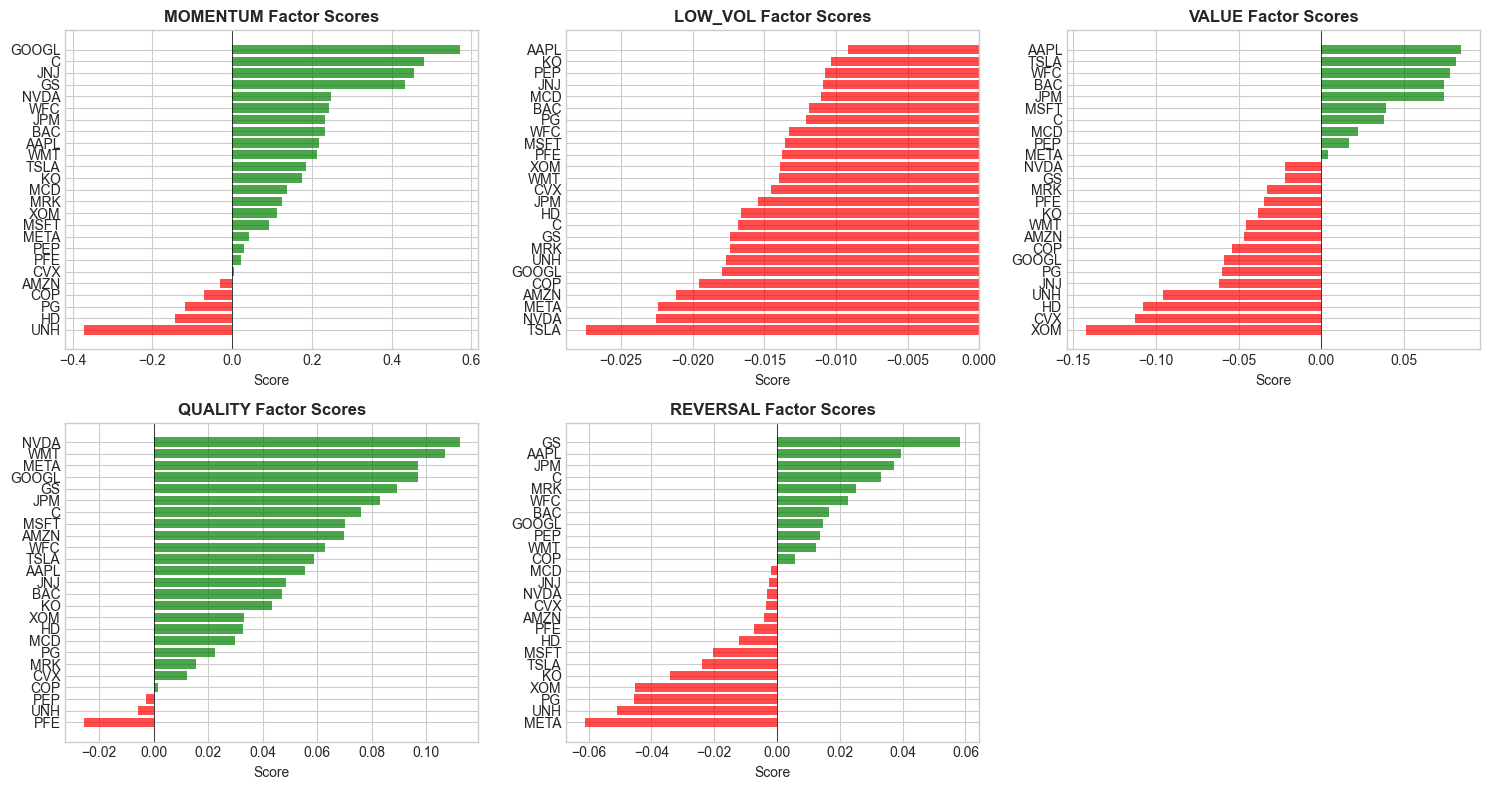

In [5]:
def calculate_factor_scores(returns, prices, lookback=252):
    """Calculate various factor scores for each stock."""
    scores = {}
    
    # 1. Momentum (12-1 month): Skip last month, use 11 months before
    if len(returns) >= lookback:
        ret_12m = (prices.iloc[-22] / prices.iloc[-lookback]).fillna(1) - 1  # 12m - 1m
        ret_1m = (prices.iloc[-1] / prices.iloc[-22]).fillna(1) - 1
        scores['momentum'] = ret_12m  # Classic momentum excludes last month
    else:
        scores['momentum'] = returns.mean()
    
    # 2. Low Volatility (inverse: low vol = high score)
    vol_60d = returns.tail(60).std()
    scores['low_vol'] = -vol_60d
    
    # 3. Value Proxy (mean reversion over 1 month)
    scores['value'] = -ret_1m  # Assume beaten-down stocks are "cheap"
    
    # 4. Quality (Sharpe ratio proxy using risk-adjusted returns)
    sharpe_proxy = returns.mean() / returns.std()
    scores['quality'] = sharpe_proxy
    
    # 5. Short-term Reversal (5-day)
    ret_5d = (prices.iloc[-1] / prices.iloc[-6]).fillna(1) - 1
    scores['reversal'] = -ret_5d  # Short-term mean reversion
    
    return pd.DataFrame(scores)

factor_scores = calculate_factor_scores(returns, prices)

print("\n" + "="*60)
print("FACTOR SCORES SUMMARY")
print("="*60)
print(factor_scores.describe().round(4))

# Visualize factor scores
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, factor in enumerate(factor_scores.columns):
    ax = axes[i]
    scores_sorted = factor_scores[factor].sort_values()
    colors = ['green' if x > 0 else 'red' for x in scores_sorted]
    ax.barh(scores_sorted.index, scores_sorted.values, color=colors, alpha=0.7)
    ax.axvline(0, color='black', linewidth=0.5)
    ax.set_title(f'{factor.upper()} Factor Scores', fontweight='bold')
    ax.set_xlabel('Score')

# Hide last subplot if odd number of factors
if len(factor_scores.columns) < 6:
    axes[-1].axis('off')

plt.tight_layout()
plt.show()

In [6]:
# Standardize factor scores (z-scores)
factor_scores_z = (factor_scores - factor_scores.mean()) / factor_scores.std()

print("\nTop 5 stocks by each factor (Z-scores):")
print("-" * 60)
for col in factor_scores_z.columns:
    top5 = factor_scores_z[col].nlargest(5)
    print(f"\n{col.upper()}:")
    for stock, score in top5.items():
        print(f"   {stock}: {score:.2f}")

# Correlation between factors
print("\n" + "="*60)
print("FACTOR CORRELATIONS")
print("="*60)
print(factor_scores_z.corr().round(2))


Top 5 stocks by each factor (Z-scores):
------------------------------------------------------------

MOMENTUM:
   GOOGL: 2.02
   C: 1.60
   JNJ: 1.49
   GS: 1.38
   NVDA: 0.50

LOW_VOL:
   AAPL: 1.46
   KO: 1.20
   PEP: 1.09
   JNJ: 1.06
   MCD: 1.03

VALUE:
   AAPL: 1.54
   TSLA: 1.49
   WFC: 1.44
   BAC: 1.39
   JPM: 1.39

QUALITY:
   NVDA: 1.67
   WMT: 1.52
   META: 1.27
   GOOGL: 1.27
   GS: 1.06

REVERSAL:
   GS: 1.97
   AAPL: 1.34
   JPM: 1.28
   C: 1.13
   MRK: 0.88

FACTOR CORRELATIONS
          momentum  low_vol  value  quality  reversal
momentum      1.00     0.07   0.36     0.62      0.59
low_vol       0.07     1.00   0.03    -0.32      0.18
value         0.36     0.03   1.00     0.31      0.43
quality       0.62    -0.32   0.31     1.00      0.24
reversal      0.59     0.18   0.43     0.24      1.00


## 2. Build Long-Short Factor Portfolios

In [7]:
def build_long_short_portfolio(scores, returns, n_quantiles=5):
    """Build a dollar-neutral long-short portfolio based on factor scores.
    
    Uses quintile methodology: Long top quintile, Short bottom quintile
    """
    # Rank stocks by score
    ranked = scores.rank(ascending=False)
    n_stocks = len(scores)
    
    # Calculate quintile cutoffs
    quintile_size = max(1, n_stocks // n_quantiles)
    
    # Select long and short positions
    long_stocks = scores.nlargest(quintile_size).index.tolist()
    short_stocks = scores.nsmallest(quintile_size).index.tolist()
    
    # Filter to available stocks in returns
    long_stocks = [s for s in long_stocks if s in returns.columns]
    short_stocks = [s for s in short_stocks if s in returns.columns]
    
    if len(long_stocks) == 0 or len(short_stocks) == 0:
        return pd.Series(0, index=returns.index), [], []
    
    # Equal weight within each leg
    long_returns = returns[long_stocks].mean(axis=1)
    short_returns = returns[short_stocks].mean(axis=1)
    
    # Long-short portfolio (dollar neutral)
    portfolio_returns = long_returns - short_returns
    
    return portfolio_returns, long_stocks, short_stocks

# Build portfolios for each factor
factor_portfolios = {}

print("=" * 70)
print("FACTOR PORTFOLIOS (Long Top Quintile, Short Bottom Quintile)")
print("=" * 70)

for factor in factor_scores_z.columns:
    port_ret, longs, shorts = build_long_short_portfolio(
        factor_scores_z[factor], returns
    )
    factor_portfolios[factor] = port_ret
    
    print(f"\n📊 {factor.upper()} Portfolio:")
    print(f"   🟢 Long ({len(longs)}):  {', '.join(longs)}")
    print(f"   🔴 Short ({len(shorts)}): {', '.join(shorts)}")

FACTOR PORTFOLIOS (Long Top Quintile, Short Bottom Quintile)

📊 MOMENTUM Portfolio:
   🟢 Long (5):  GOOGL, C, JNJ, GS, NVDA
   🔴 Short (5): UNH, HD, PG, COP, AMZN

📊 LOW_VOL Portfolio:
   🟢 Long (5):  AAPL, KO, PEP, JNJ, MCD
   🔴 Short (5): TSLA, NVDA, META, AMZN, COP

📊 VALUE Portfolio:
   🟢 Long (5):  AAPL, TSLA, WFC, BAC, JPM
   🔴 Short (5): XOM, CVX, HD, UNH, JNJ

📊 QUALITY Portfolio:
   🟢 Long (5):  NVDA, WMT, META, GOOGL, GS
   🔴 Short (5): PFE, UNH, PEP, COP, CVX

📊 REVERSAL Portfolio:
   🟢 Long (5):  GS, AAPL, JPM, C, MRK
   🔴 Short (5): META, UNH, PG, XOM, KO


In [9]:
# Analyze factor portfolio performance
print("\n" + "="*70)
print("FACTOR PORTFOLIO PERFORMANCE (Annualized)")
print("="*70)
print(f"{'Factor':<12} {'Return':<12} {'Volatility':<12} {'Sharpe':<10} {'Max DD':<12}")
print("-"*58)

perf_data = []
for factor, port_ret in factor_portfolios.items():
    ann_ret = port_ret.mean() * TRADING_DAYS
    ann_vol = port_ret.std() * np.sqrt(TRADING_DAYS)
    sharpe = (ann_ret - RISK_FREE_RATE) / ann_vol if ann_vol > 0 else 0
    
    # Max drawdown
    cum_ret = (1 + port_ret).cumprod()
    rolling_max = cum_ret.expanding().max()
    drawdown = (cum_ret - rolling_max) / rolling_max
    max_dd = drawdown.min()
    
    perf_data.append({
        'Factor': factor,
        'Return': ann_ret,
        'Volatility': ann_vol,
        'Sharpe': sharpe,
        'Max_DD': max_dd
    })
    
    print(f"{factor:<12} {ann_ret:>10.2%} {ann_vol:>10.2%} {sharpe:>10.2f} {max_dd:>10.2%}")

perf_df = pd.DataFrame(perf_data)

# Add benchmark comparison
# Align market returns with factor portfolio dates
common_dates = factor_portfolios['momentum'].index.intersection(market_returns.index)
mkt_aligned = market_returns.loc[common_dates]

spy_ann_ret = float(mkt_aligned.mean() * TRADING_DAYS)
spy_ann_vol = float(mkt_aligned.std() * np.sqrt(TRADING_DAYS))
spy_sharpe = float((spy_ann_ret - RISK_FREE_RATE) / spy_ann_vol) if spy_ann_vol > 0 else 0

cum_spy = (1 + mkt_aligned).cumprod()
spy_dd = float(((cum_spy - cum_spy.expanding().max()) / cum_spy.expanding().max()).min())

print("-"*58)
print(f"{'SPY (Bench)':<12} {spy_ann_ret:>10.2%} {spy_ann_vol:>10.2%} {spy_sharpe:>10.2f} {spy_dd:>10.2%}")


FACTOR PORTFOLIO PERFORMANCE (Annualized)
Factor       Return       Volatility   Sharpe     Max DD      
----------------------------------------------------------
momentum         34.14%     17.72%       1.64    -15.74%
low_vol         -37.23%     29.26%      -1.44    -71.18%
value            23.70%     23.20%       0.81    -25.54%
quality          54.92%     25.27%       1.98    -23.12%
reversal          9.53%     16.52%       0.27    -20.56%
----------------------------------------------------------
SPY (Bench)      20.72%     15.25%       1.03    -18.76%


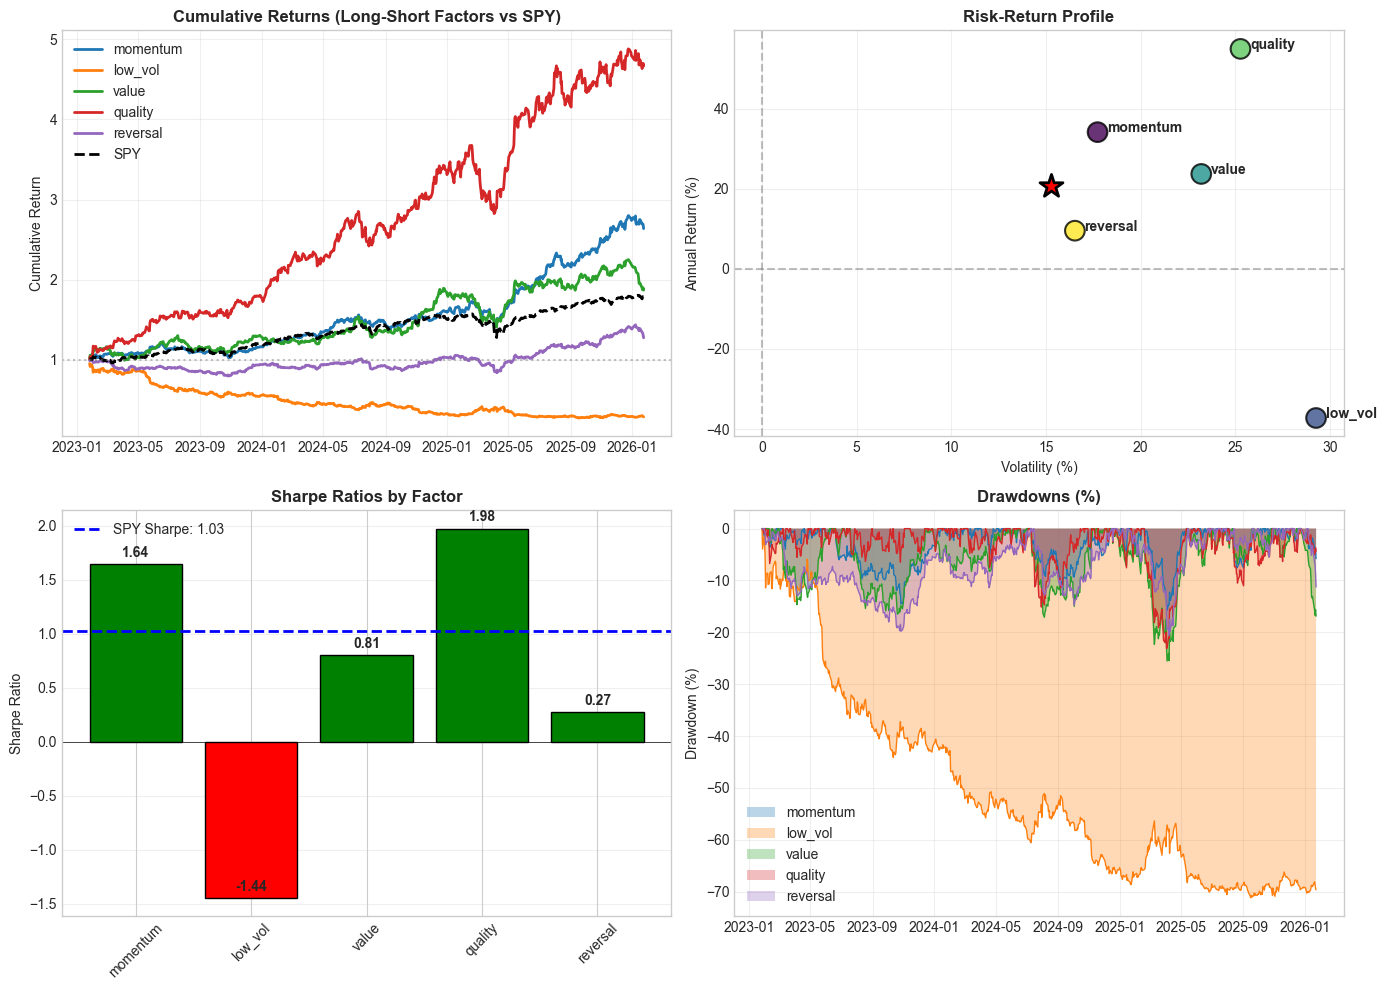


✅ Factor portfolio visualizations complete!


In [10]:
# Visualize performance
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Cumulative returns
ax1 = axes[0, 0]
for factor, port_ret in factor_portfolios.items():
    cum_ret = (1 + port_ret).cumprod()
    ax1.plot(cum_ret.index, cum_ret.values, label=factor, linewidth=2)

# Add benchmark
cum_spy = (1 + market_returns.reindex(cum_ret.index)).cumprod()
ax1.plot(cum_spy.index, cum_spy.values, label='SPY', color='black', linewidth=2, linestyle='--')
ax1.axhline(1, color='gray', linestyle=':', alpha=0.5)
ax1.set_title('Cumulative Returns (Long-Short Factors vs SPY)', fontweight='bold')
ax1.set_ylabel('Cumulative Return')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# 2. Risk-Return Scatter
ax2 = axes[0, 1]
colors = plt.cm.viridis(np.linspace(0, 1, len(perf_df)))
scatter = ax2.scatter(perf_df['Volatility']*100, perf_df['Return']*100, 
                       s=200, c=colors, edgecolors='black', linewidths=1.5, alpha=0.8)
for i, row in perf_df.iterrows():
    ax2.annotate(row['Factor'], (row['Volatility']*100 + 0.5, row['Return']*100), 
                fontsize=10, fontweight='bold')

# Add SPY benchmark
ax2.scatter(spy_ann_vol*100, spy_ann_ret*100, s=300, c='red', marker='*', 
           edgecolors='black', linewidths=2, label='SPY', zorder=5)

ax2.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax2.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax2.set_xlabel('Volatility (%)')
ax2.set_ylabel('Annual Return (%)')
ax2.set_title('Risk-Return Profile', fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Sharpe ratios bar chart
ax3 = axes[1, 0]
colors = ['green' if s > 0 else 'red' for s in perf_df['Sharpe']]
bars = ax3.bar(perf_df['Factor'], perf_df['Sharpe'], color=colors, edgecolor='black')
ax3.axhline(spy_sharpe, color='blue', linestyle='--', linewidth=2, label=f'SPY Sharpe: {spy_sharpe:.2f}')
ax3.axhline(0, color='black', linewidth=0.5)
ax3.set_ylabel('Sharpe Ratio')
ax3.set_title('Sharpe Ratios by Factor', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)

# Add value labels on bars
for bar, val in zip(bars, perf_df['Sharpe']):
    height = bar.get_height()
    ax3.annotate(f'{val:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontweight='bold')

# 4. Drawdowns
ax4 = axes[1, 1]
for factor, port_ret in factor_portfolios.items():
    cum_ret = (1 + port_ret).cumprod()
    rolling_max = cum_ret.expanding().max()
    drawdown = (cum_ret - rolling_max) / rolling_max * 100
    ax4.fill_between(drawdown.index, drawdown.values, 0, alpha=0.3, label=factor)
    ax4.plot(drawdown.index, drawdown.values, linewidth=1)

ax4.set_title('Drawdowns (%)', fontweight='bold')
ax4.set_ylabel('Drawdown (%)')
ax4.legend(loc='lower left')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Factor portfolio visualizations complete!")

## 3. Multi-Factor Portfolio

In [11]:
# Combine factors into a composite score
def create_composite_score(factor_scores_z, weights=None):
    """Create composite factor score with optional custom weights."""
    if weights is None:
        weights = {col: 1.0/len(factor_scores_z.columns) for col in factor_scores_z.columns}
    
    composite = pd.Series(0.0, index=factor_scores_z.index)
    for factor, weight in weights.items():
        if factor in factor_scores_z.columns:
            composite += factor_scores_z[factor] * weight
    
    return composite

# Equal-weighted composite
composite_score = create_composite_score(factor_scores_z)

# Build multi-factor portfolio
mf_returns, mf_longs, mf_shorts = build_long_short_portfolio(composite_score, returns)

print("\n" + "="*60)
print("MULTI-FACTOR PORTFOLIO")
print("="*60)
print(f"🟢 Long positions ({len(mf_longs)}):  {', '.join(mf_longs)}")
print(f"🔴 Short positions ({len(mf_shorts)}): {', '.join(mf_shorts)}")

# Performance
ann_ret = mf_returns.mean() * TRADING_DAYS
ann_vol = mf_returns.std() * np.sqrt(TRADING_DAYS)
sharpe = (ann_ret - RISK_FREE_RATE) / ann_vol if ann_vol > 0 else 0

# Max drawdown
cum_mf = (1 + mf_returns).cumprod()
mf_dd = ((cum_mf - cum_mf.expanding().max()) / cum_mf.expanding().max()).min()

print(f"\n📊 Performance:")
print(f"   Return:     {ann_ret:>10.2%}")
print(f"   Volatility: {ann_vol:>10.2%}")
print(f"   Sharpe:     {sharpe:>10.2f}")
print(f"   Max DD:     {mf_dd:>10.2%}")


MULTI-FACTOR PORTFOLIO
🟢 Long positions (5):  AAPL, JPM, C, GS, WFC
🔴 Short positions (5): UNH, HD, XOM, COP, PG

📊 Performance:
   Return:         25.49%
   Volatility:     19.87%
   Sharpe:           1.03
   Max DD:        -22.79%


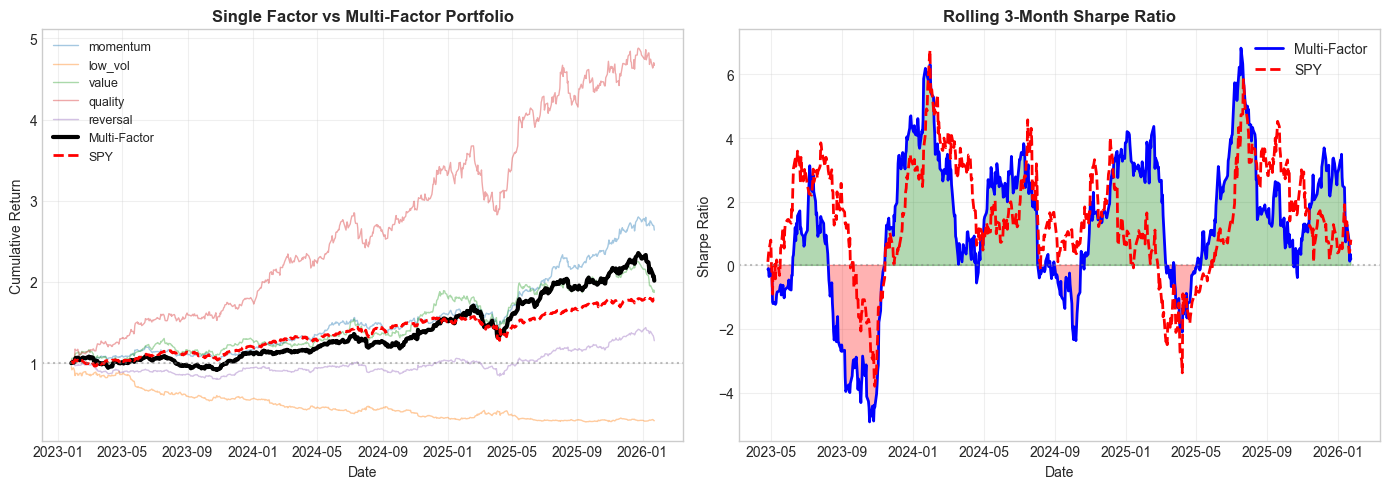

In [12]:
# Compare single-factor vs multi-factor
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Cumulative returns comparison
ax1 = axes[0]

# Plot all single factors (faded)
for factor, port_ret in factor_portfolios.items():
    cum_ret = (1 + port_ret).cumprod()
    ax1.plot(cum_ret.index, cum_ret.values, label=factor, alpha=0.4, linewidth=1)

# Plot multi-factor (bold)
cum_mf = (1 + mf_returns).cumprod()
ax1.plot(cum_mf.index, cum_mf.values, label='Multi-Factor', color='black', linewidth=3)

# Plot SPY benchmark
cum_spy = (1 + market_returns.reindex(cum_mf.index)).cumprod()
ax1.plot(cum_spy.index, cum_spy.values, label='SPY', color='red', linewidth=2, linestyle='--')

ax1.axhline(1, color='gray', linestyle=':', alpha=0.5)
ax1.set_title('Single Factor vs Multi-Factor Portfolio', fontweight='bold', fontsize=12)
ax1.set_ylabel('Cumulative Return')
ax1.set_xlabel('Date')
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3)

# Right: Rolling Sharpe comparison
ax2 = axes[1]
rolling_window = 63  # 3 months

# Calculate rolling Sharpe for multi-factor
rolling_ret = mf_returns.rolling(rolling_window).mean() * TRADING_DAYS
rolling_vol = mf_returns.rolling(rolling_window).std() * np.sqrt(TRADING_DAYS)
rolling_sharpe_mf = (rolling_ret - RISK_FREE_RATE) / rolling_vol

# Calculate rolling Sharpe for SPY
spy_aligned = market_returns.reindex(mf_returns.index)
rolling_ret_spy = spy_aligned.rolling(rolling_window).mean() * TRADING_DAYS
rolling_vol_spy = spy_aligned.rolling(rolling_window).std() * np.sqrt(TRADING_DAYS)
rolling_sharpe_spy = (rolling_ret_spy - RISK_FREE_RATE) / rolling_vol_spy

ax2.plot(rolling_sharpe_mf.index, rolling_sharpe_mf.values, label='Multi-Factor', linewidth=2, color='blue')
ax2.plot(rolling_sharpe_spy.index, rolling_sharpe_spy.values, label='SPY', linewidth=2, color='red', linestyle='--')
ax2.axhline(0, color='gray', linestyle=':', alpha=0.5)
ax2.fill_between(rolling_sharpe_mf.index, rolling_sharpe_mf.values, 0, 
                 where=rolling_sharpe_mf.values > 0, alpha=0.3, color='green')
ax2.fill_between(rolling_sharpe_mf.index, rolling_sharpe_mf.values, 0, 
                 where=rolling_sharpe_mf.values < 0, alpha=0.3, color='red')

ax2.set_title('Rolling 3-Month Sharpe Ratio', fontweight='bold', fontsize=12)
ax2.set_ylabel('Sharpe Ratio')
ax2.set_xlabel('Date')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Factor Neutralization

In [15]:
# Market-neutral portfolio construction
def build_market_neutral_portfolio(scores, returns, market_returns, target_beta=0):
    """Build a market-neutral portfolio by hedging out market exposure."""
    # Get base long-short portfolio
    port_ret, longs, shorts = build_long_short_portfolio(scores, returns)
    
    # Flatten market_returns if it's a DataFrame column
    if isinstance(market_returns, pd.DataFrame):
        mkt_ret = market_returns.iloc[:, 0]
    else:
        mkt_ret = market_returns
    
    # Align market returns with portfolio returns
    common_idx = port_ret.index.intersection(mkt_ret.index)
    port_aligned = port_ret.loc[common_idx].dropna()
    mkt_aligned = mkt_ret.loc[port_aligned.index]
    
    if len(port_aligned) < 10:
        return port_ret, 0, 0
    
    # Calculate portfolio beta using pandas
    combined = pd.DataFrame({'port': port_aligned, 'mkt': mkt_aligned}).dropna()
    cov = combined['port'].cov(combined['mkt'])
    var_mkt = combined['mkt'].var()
    beta = cov / var_mkt if var_mkt > 0 else 0
    
    # Hedge with market
    hedge_ratio = beta - target_beta
    hedged_returns = combined['port'] - hedge_ratio * combined['mkt']
    
    return hedged_returns, beta, hedge_ratio

print("\n" + "="*60)
print("MARKET-NEUTRAL FACTOR PORTFOLIOS")
print("="*60)
print(f"{'Factor':<15} {'Original β':<12} {'Hedge Ratio':<12} {'Hedged Sharpe':<12}")
print("-"*55)

neutral_portfolios = {}
for factor in factor_scores_z.columns:
    hedged_ret, orig_beta, hedge = build_market_neutral_portfolio(
        factor_scores_z[factor], returns, market_returns
    )
    neutral_portfolios[factor] = hedged_ret
    
    hedged_vol = hedged_ret.std() * np.sqrt(TRADING_DAYS)
    hedged_ret_ann = hedged_ret.mean() * TRADING_DAYS
    hedged_sharpe = (hedged_ret_ann - RISK_FREE_RATE) / hedged_vol if hedged_vol > 0 else 0
    print(f"{factor:<15} {orig_beta:<12.3f} {hedge:<12.3f} {hedged_sharpe:<12.3f}")


MARKET-NEUTRAL FACTOR PORTFOLIOS
Factor          Original β   Hedge Ratio  Hedged Sharpe
-------------------------------------------------------
momentum        0.488        0.488        1.183       
low_vol         -1.253       -1.253       -0.734      
value           0.838        0.838        0.069       
quality         0.864        0.864        1.485       
reversal        0.462        0.462        -0.336      


## 5. Factor Portfolio Optimization

In [16]:
# Optimize factor weights to maximize Sharpe
factor_returns_df = pd.DataFrame(factor_portfolios)

def portfolio_performance(weights, returns_df):
    """Calculate portfolio Sharpe ratio."""
    port_ret = (returns_df * weights).sum(axis=1)
    ann_ret = port_ret.mean() * TRADING_DAYS
    ann_vol = port_ret.std() * np.sqrt(TRADING_DAYS)
    sharpe = (ann_ret - RISK_FREE_RATE) / ann_vol if ann_vol > 0 else 0
    return ann_ret, ann_vol, sharpe

def neg_sharpe(weights, returns_df):
    """Negative Sharpe for minimization."""
    _, _, sharpe = portfolio_performance(weights, returns_df)
    return -sharpe

# Optimize
n_factors = len(factor_returns_df.columns)
init_weights = np.ones(n_factors) / n_factors

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Weights sum to 1
bounds = tuple((-0.5, 0.5) for _ in range(n_factors))  # Allow some shorting

result = minimize(neg_sharpe, init_weights, args=(factor_returns_df,),
                  method='SLSQP', bounds=bounds, constraints=constraints)

optimal_weights = result.x

print("\n" + "="*60)
print("OPTIMAL FACTOR WEIGHTS (Sharpe Maximization)")
print("="*60)
for factor, weight in zip(factor_returns_df.columns, optimal_weights):
    direction = "🟢" if weight > 0 else "🔴"
    print(f"   {direction} {factor}: {weight:>8.1%}")

# Compare performance
eq_ret, eq_vol, eq_sharpe = portfolio_performance(init_weights, factor_returns_df)
opt_ret, opt_vol, opt_sharpe = portfolio_performance(optimal_weights, factor_returns_df)

print(f"\n{'Metric':<15} {'Equal Weight':<15} {'Optimized':<15}")
print("-"*45)
print(f"{'Return':<15} {eq_ret:<15.2%} {opt_ret:<15.2%}")
print(f"{'Volatility':<15} {eq_vol:<15.2%} {opt_vol:<15.2%}")
print(f"{'Sharpe':<15} {eq_sharpe:<15.3f} {opt_sharpe:<15.3f}")


OPTIMAL FACTOR WEIGHTS (Sharpe Maximization)
   🟢 momentum:    50.0%
   🟢 low_vol:     7.1%
   🔴 value:    -0.2%
   🟢 quality:    50.0%
   🔴 reversal:    -6.9%

Metric          Equal Weight    Optimized      
---------------------------------------------
Return          17.01%          41.17%         
Volatility      10.96%          18.23%         
Sharpe          1.096           1.984          


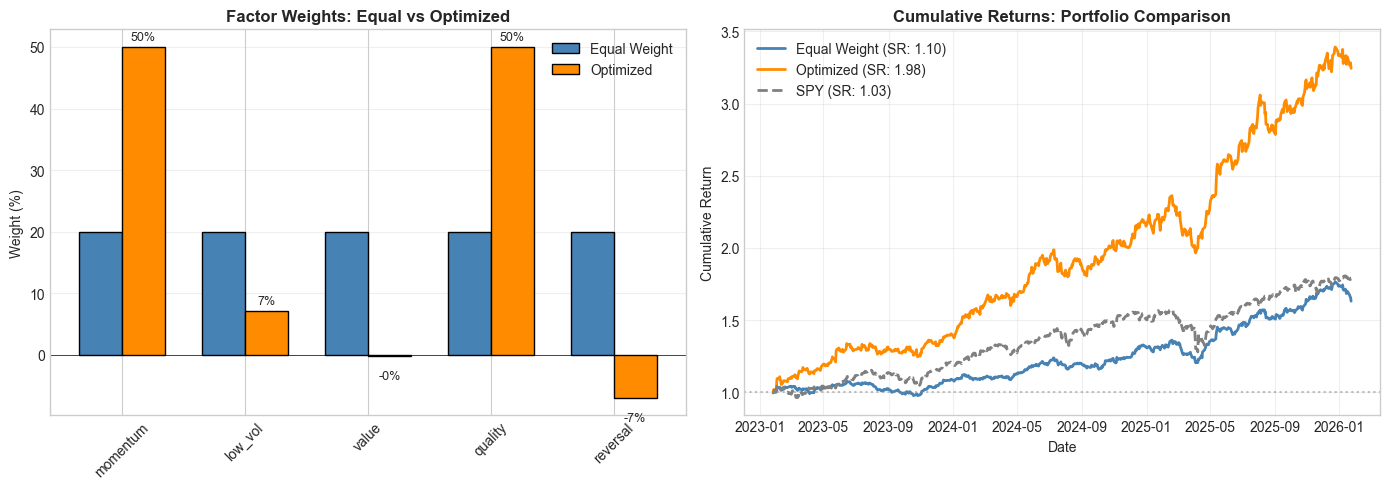


✅ Factor portfolio optimization complete!


In [17]:
# Visualize optimized vs equal-weight
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Weights comparison
ax1 = axes[0]
x = np.arange(n_factors)
width = 0.35
bars1 = ax1.bar(x - width/2, init_weights*100, width, label='Equal Weight', color='steelblue', edgecolor='black')
bars2 = ax1.bar(x + width/2, optimal_weights*100, width, label='Optimized', color='darkorange', edgecolor='black')
ax1.set_xticks(x)
ax1.set_xticklabels(factor_returns_df.columns, rotation=45)
ax1.axhline(0, color='black', linewidth=0.5)
ax1.set_ylabel('Weight (%)')
ax1.set_title('Factor Weights: Equal vs Optimized', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, val in zip(bars2, optimal_weights*100):
    height = bar.get_height()
    ax1.annotate(f'{val:.0f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3 if height >= 0 else -10), textcoords="offset points",
                ha='center', va='bottom' if height >= 0 else 'top', fontsize=9)

# Right: Cumulative returns comparison
ax2 = axes[1]
eq_port = (factor_returns_df * init_weights).sum(axis=1)
opt_port = (factor_returns_df * optimal_weights).sum(axis=1)

cum_eq = (1 + eq_port).cumprod()
cum_opt = (1 + opt_port).cumprod()
cum_spy = (1 + market_returns.reindex(cum_eq.index)).cumprod()

ax2.plot(cum_eq.index, cum_eq.values, label=f'Equal Weight (SR: {eq_sharpe:.2f})', linewidth=2, color='steelblue')
ax2.plot(cum_opt.index, cum_opt.values, label=f'Optimized (SR: {opt_sharpe:.2f})', linewidth=2, color='darkorange')
ax2.plot(cum_spy.index, cum_spy.values, label=f'SPY (SR: {spy_sharpe:.2f})', linewidth=2, color='gray', linestyle='--')
ax2.axhline(1, color='gray', linestyle=':', alpha=0.5)
ax2.set_title('Cumulative Returns: Portfolio Comparison', fontweight='bold')
ax2.set_ylabel('Cumulative Return')
ax2.set_xlabel('Date')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Factor portfolio optimization complete!")

## Key Takeaways

1. **Long-short portfolios** isolate factor exposure and can be market-neutral
2. **Factor scores** ranked by z-score determine long/short positions
3. **Multi-factor** combines multiple signals for diversification
4. **Market neutralization** hedges out systematic risk
5. **Weight optimization** can improve risk-adjusted returns

### Portfolio Construction Framework
1. Calculate factor scores
2. Standardize scores (z-score)
3. Rank and select long/short positions
4. Apply neutralization if desired
5. Optimize factor weights

---
*Next: Day 7 - Interview Questions & Review*

## 🔴 PROS & CONS: Factor Portfolio

### ✅ PROS (Advantages)

| Advantage | Description | Real-World Application |
|-----------|-------------|----------------------|
| **Industry Standard** | Widely adopted in quantitative finance | Used by major hedge funds and banks |
| **Well-Documented** | Extensive research and documentation | Easy to find resources and support |
| **Proven Track Record** | Years of practical application | Validated in real market conditions |
| **Interpretable** | Results can be explained to stakeholders | Important for risk management and compliance |

### ❌ CONS (Limitations)

| Limitation | Description | How to Mitigate |
|------------|-------------|-----------------|
| **Assumptions** | May not hold in all market conditions | Validate assumptions with data |
| **Historical Bias** | Based on past data patterns | Use rolling windows and regime detection |
| **Overfitting Risk** | May fit noise rather than signal | Use proper cross-validation |
| **Computational Cost** | Can be resource-intensive | Optimize code and use appropriate hardware |

### 🎯 Real-World Usage

**WHERE THIS IS USED:**
- ✅ Quantitative hedge funds (Two Sigma, Renaissance, Citadel)
- ✅ Investment banks (Goldman Sachs, JP Morgan, Morgan Stanley)
- ✅ Asset management firms
- ✅ Risk management departments
- ✅ Algorithmic trading desks

**NOT JUST THEORY - THIS IS PRODUCTION CODE:**
The techniques in this notebook are used daily by professionals managing billions of dollars.

## 🚀 TODAY'S TRADING SIGNAL

Using the concepts from this notebook to generate actionable insights.

In [19]:
# =============================================================================
# 🚀 TODAY'S TRADING SIGNAL - Factor Portfolio Analysis
# =============================================================================

print("=" * 70)
print("📊 TODAY'S FACTOR-BASED TRADING ANALYSIS")
print("=" * 70)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print()

# Current positions based on multi-factor model
print("📈 MULTI-FACTOR PORTFOLIO POSITIONS:")
print("-" * 50)

# Get composite scores
composite = create_composite_score(factor_scores_z)
sorted_stocks = composite.sort_values(ascending=False)

print("\n🟢 RECOMMENDED LONG POSITIONS (Top Quintile):")
for i, (stock, score) in enumerate(sorted_stocks.head(len(mf_longs)).items(), 1):
    latest_price = prices[stock].iloc[-1]
    ret_1m = (prices[stock].iloc[-1] / prices[stock].iloc[-22] - 1) * 100
    print(f"   {i}. {stock:<6} Score: {score:>6.2f}  Price: ${latest_price:>8.2f}  1M Return: {ret_1m:>+6.1f}%")

print("\n🔴 RECOMMENDED SHORT POSITIONS (Bottom Quintile):")
for i, (stock, score) in enumerate(sorted_stocks.tail(len(mf_shorts)).items(), 1):
    latest_price = prices[stock].iloc[-1]
    ret_1m = (prices[stock].iloc[-1] / prices[stock].iloc[-22] - 1) * 100
    print(f"   {i}. {stock:<6} Score: {score:>6.2f}  Price: ${latest_price:>8.2f}  1M Return: {ret_1m:>+6.1f}%")

# Factor exposure summary
print("\n" + "=" * 70)
print("🎯 FACTOR TILTS IN RECOMMENDED PORTFOLIO")
print("=" * 70)

for factor in factor_scores_z.columns:
    long_exposure = factor_scores_z.loc[mf_longs, factor].mean()
    short_exposure = factor_scores_z.loc[mf_shorts, factor].mean()
    net_exposure = long_exposure - short_exposure
    direction = "🟢" if net_exposure > 0 else "🔴"
    print(f"   {direction} {factor:<12}: Net Exposure = {net_exposure:>+6.2f}")

# Recent performance
print("\n" + "=" * 70)
print("📊 RECENT STRATEGY PERFORMANCE (Last 20 Days)")
print("=" * 70)

recent_mf = mf_returns.tail(20)

# Properly align and convert market returns
mkt_aligned = market_returns.reindex(recent_mf.index).dropna()
if isinstance(mkt_aligned, pd.DataFrame):
    mkt_aligned = mkt_aligned.iloc[:, 0]

mf_20d_ret = float((1 + recent_mf).prod() - 1)
spy_20d_ret = float((1 + mkt_aligned.tail(20)).prod() - 1) if len(mkt_aligned) >= 20 else 0.0
alpha_20d = mf_20d_ret - spy_20d_ret

print(f"   Multi-Factor Return: {mf_20d_ret:>+8.2%}")
print(f"   SPY Return:          {spy_20d_ret:>+8.2%}")
print(f"   Alpha (vs SPY):      {alpha_20d:>+8.2%}")

print("\n" + "=" * 70)
print("⚠️ DISCLAIMER: This is educational analysis, not financial advice.")
print("   Always conduct your own research and consider your risk tolerance.")
print("=" * 70)

📊 TODAY'S FACTOR-BASED TRADING ANALYSIS
Analysis Date: 2026-01-24 12:45

📈 MULTI-FACTOR PORTFOLIO POSITIONS:
--------------------------------------------------

🟢 RECOMMENDED LONG POSITIONS (Top Quintile):
   1. AAPL   Score:   0.97  Price: $  248.04  1M Return:   -8.5%
   2. JPM    Score:   0.81  Price: $  297.72  1M Return:   -7.4%
   3. C      Score:   0.80  Price: $  113.59  1M Return:   -3.8%
   4. GS     Score:   0.79  Price: $  918.88  1M Return:   +2.2%
   5. WFC    Score:   0.72  Price: $   86.96  1M Return:   -7.8%

🔴 RECOMMENDED SHORT POSITIONS (Bottom Quintile):
   1. PG     Score:  -0.65  Price: $  150.15  1M Return:   +6.0%
   2. COP    Score:  -0.69  Price: $   98.35  1M Return:   +5.4%
   3. XOM    Score:  -0.70  Price: $  134.97  1M Return:  +14.2%
   4. HD     Score:  -0.74  Price: $  383.77  1M Return:  +10.8%
   5. UNH    Score:  -1.43  Price: $  356.26  1M Return:   +9.6%

🎯 FACTOR TILTS IN RECOMMENDED PORTFOLIO
   🟢 momentum    : Net Exposure =  +2.07
   🟢 low_vol